In [1]:
# carico i modelli dalla mia repository

def get_dbn_library():
  files = ["RBM.py", "Linear_model_tf.py"]
  repository_url = "https://raw.githubusercontent.com/LorenzoTausani/DBN/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_dbn_library()

import RBM
import Linear_model_tf

# Importing the libraries
#from RBM_Padella2 import RBM
from Linear_model_tf import LinearClassifier

from RBM import RBM

import torch 
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import math
import numpy as np
import os
import random
import pandas as pd
import time

import pickle

from sklearn.decomposition import PCA
from sklearn import decomposition

#device in use
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {DEVICE}")

--2022-05-16 23:00:02--  https://raw.githubusercontent.com/LorenzoTausani/DBN/master/RBM.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16343 (16K) [text/plain]
Saving to: ‘RBM.py’

RBM.py              100%[===================>]  15.96K  --.-KB/s    in 0.001s  

2022-05-16 23:00:02 (30.7 MB/s) - ‘RBM.py’ saved [16343/16343]

--2022-05-16 23:00:02--  https://raw.githubusercontent.com/LorenzoTausani/DBN/master/Linear_model_tf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284 [text/plain]
Saving to: ‘Linear_model_tf.py’

Lin

In [15]:
def seed_everything(seed=42):
    """Seed everything to make the code more reproducable.

    This code is the same as that found from many public Kaggle kernels.

    Parameters
    ----------
    seed: int
        seed value to ues

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def load_model(filename):

    filename = '/content/gdrive/My Drive/' + filename + '/' + filename + '.pkl'

    from google.colab import drive
    drive.mount('/content/gdrive')

    with open(filename, 'rb') as inp:
        model = pickle.load(inp)

    return model


def PCA_explainedVariance_plot(px, model):

  pca = decomposition.PCA()

  # PCA for dimensionality redcution (non-visualization)
  pca.n_components = model.hidden_units
  pca_data = pca.fit_transform(px)
  percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
  cum_var_explained = np.cumsum(percentage_var_explained)

  # Plot the PCA spectrum
  plt.figure(1, figsize=(6, 4))
  plt.clf()
  plt.plot(cum_var_explained, linewidth=2)
  plt.axis('tight')
  plt.grid()
  plt.xlabel('n_components')
  plt.ylabel('Cumulative_explained_variance')
  plt.savefig("PCA_explained_variance.jpg")
  plt.show()

def PCA_analysis(px,y):
  # create two PCA components
  sklearn_pca = PCA(n_components=2)
  Y_sklearn = sklearn_pca.fit_transform(px)

  # Additional processing of PCA
  #print(sklearn_pca.components_) #array [ncomponents, nfeatures]
  #print(sklearn_pca.explained_variance_)  #var explained by each component
  print('explained variance per component: ',sklearn_pca.explained_variance_ratio_) #percentage explained by each component

  def eigsorted(cov):
      vals, vecs = np.linalg.eigh(cov) #Return the eigenvalues and eigenvectors of the covariance matrix
      order = vals.argsort()[::-1] 
      return vals[order], vecs[:,order]

  Eu_dist=[]

  with plt.style.context('seaborn-whitegrid'):

      # only one plot
      fig, ax = plt.subplots(figsize=(10, 8))

      for lab, col in zip((0,1,2,3,4,5,6,7,8,9),
                          ('k','r', 'g', 'b','y', 'm', 'c', 'darkorange', 'grey', 'deeppink')):

          # The following two lines subset the data based on the factor "lab" above
          # y==lab returns an array of true or false, and the number specifies the 
          # column to return from the dataset (here the dataset is Y_sklearn)
          # The output for xdata and ydata is a vector of length that matches 'lab = true'  
          xdata = Y_sklearn[y==lab, 0]
          ydata = Y_sklearn[y==lab, 1]



          # get values to build the ellipse
          cov = np.cov(xdata, ydata) #Estimate a covariance matrix
          vals, vecs = eigsorted(cov)
          theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
          w, h = 2 * 2 * np.sqrt(vals)

          # create the ellipse
          ell = Ellipse(xy=(np.mean(xdata), np.mean(ydata)),
                width=w, height=h,
                angle=theta, color='black', alpha=0.2)

          ell.set_facecolor(col) # reference the colour for each factor (defined by lab)
          ax.add_artist(ell)
          
          ax.scatter(xdata, ydata,
                    label=lab, # use labels provided above
                    c=col, # use colors provided above
                    lw = 0, #remove the outer line of each point
                    alpha=0.7, # increase transparency of points
                    s=10) # increase the size of points
          euclidean_distances =[]
          PC1_2=np.column_stack((xdata, ydata))
          cluster_center= np.array([np.mean(xdata), np.mean(ydata)])
          
          if lab == 0:
            Centers = cluster_center
          else:
            Centers=np.row_stack((Centers, cluster_center))

          for row in PC1_2:

            #print (str(row))
            euclidean_distances.append(np.linalg.norm(row - cluster_center))

          print('avg euclidean distance, label='+str(lab)+' : '+ str(sum(euclidean_distances) / len(euclidean_distances)))
          Eu_dist.append(sum(euclidean_distances) / len(euclidean_distances))


      #the mean distance between the cluster center and all other centers
      
      Center_dists=[]
      counter=0
      for row1 in Centers:
        sum_dist = 0
        for row2 in Centers:
          sum_dist= sum_dist+np.linalg.norm(row1 - row2)

              
        Center_dists.append(sum_dist/(10-1))
        print('mean distance between the cluster center and all other centers, label '+str(counter)+' = '+str(sum_dist/(10-1)))
        counter =counter+1
      Avg_Cluster_distance = sum(Center_dists)/len(Center_dists) 
      
      avg_Cluster_radius = sum(Eu_dist) / len(Eu_dist)

      Clustering_idx = 1 - avg_Cluster_radius/Avg_Cluster_distance
      # add labels showing percentage of the variance explained
      print('avg cluster distance : '+str(Avg_Cluster_distance))
      print('avg cluster radius: '+str(avg_Cluster_radius))
      print('clustering index: '+str(Clustering_idx))
      ax.set_xlabel('Principal Component 1 (%{:.2f})'.format(sklearn_pca.explained_variance_ratio_[0]*100), fontsize=20)
      ax.set_ylabel('Principal Component 2 (%{:.2f})'.format(sklearn_pca.explained_variance_ratio_[1]*100), fontsize=20)

      plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
      plt.savefig("PCA_analysis.jpg")
      plt.show()

      return Clustering_idx, avg_Cluster_radius, Avg_Cluster_distance

def model_load_or_create():
  Load_yn=int(input('do you want to load an old model? (1=yes, 0=no)'))

  if Load_yn==1:
    nr_train_epochs_done=int(input('quante epoche di training della RBM?'))
    h_train_size = int(input('quanti h train generati (0 se nessuno)?'))
    nr_gibbs_htrain = int(input('con quanti gibbs steps?'))
    h_test_size = int(input('quanti h test generati (0 se nessuno)?'))
    nr_gibbs_htest = int(input('con quanti gibbs steps?'))


    filename = 'rbm_train'+ str(nr_train_epochs_done)+'_generated_h_train'+str(h_train_size)+'gibbs'+str(nr_gibbs_htrain)+'_generated_h_test'+str(h_test_size)+'gibbs'+str(nr_gibbs_htest)
    model = load_model(filename)

  else:
    model = RBM(visible_units=28*28 ,
                hidden_units= 500, #standard: 23*23
                k = 1, #initial =5 
                learning_rate = 0.01, #standard: 0.1
                learning_rate_decay = False,
                xavier_init = True,
                increase_to_cd_k = False,
                use_gpu = False) #nota: use_gpu ora e useless


  num_epochs = int(input('trainare la rete? quante epoche? (0 se non si vuole trainare'))

  if num_epochs >0:
    tmp = mnist_data.data
    train_labels = mnist_data.train_labels

    batch_size = 50

    tensor_x = tmp.type(torch.FloatTensor).to(DEVICE) # transform to torch tensors
    tensor_y = train_labels.type(torch.FloatTensor).to(DEVICE)
    _dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    _dataloader = torch.utils.data.DataLoader(_dataset,batch_size=batch_size,drop_last = True) # create your dataloader


    start = time.time()

    Avg_cost, Std_cost = model.train( _dataloader , num_epochs, batch_size)

    end = time.time()

    print(end - start)


  dati_generati_yn = int(input('creare nuovi dati generati (0=no, 1=si, 2=reset)'))

  if dati_generati_yn ==2:
    model.reset_h_tran_test_set(train=False, test=True)

  if dati_generati_yn ==1 or dati_generati_yn ==2:

    nt_tr_h = int(input('aggungere dei train h? quanti dati? (0 se non si vuole trainare'))

    if nt_tr_h>0:
      model.create_h_tran_test_set(mnist_data.train_data, mnist_data.train_labels , nr_train_el=nt_tr_h, nr_test_el=0, nr_gibbs=1)

    nt_te_h = int(input('aggungere dei test h? quanti dati? (0 se non si vuole trainare'))
    if hasattr(model, 'nr_gibbs_test'):
      gib_nr = model.nr_gibbs_test
    else:
      gib_nr = int(input('quanti gibbs steps?'))

    

    if nt_te_h > 0:
      model.create_h_tran_test_set(mnist_data.train_data, mnist_data.train_labels , nr_train_el=0, nr_test_el=nt_te_h, nr_gibbs=gib_nr)

  else:
    gib_nr = model.nr_gibbs_test

  model.train_h_Linear_classifier()

  save_yn = int(input('salvare il modello? (0=no, 1=si)'))

  if save_yn ==1:
    model.save_model(nr_gibbs_htest=gib_nr)

  return (model,gib_nr)

In [11]:
#plotting functions
def Reconstuct_plot(mnist_data,model):

    figure, axis = plt.subplots(2, 10, figsize=(25,5))
    

    for lbl in range(10):

        idx = int(torch.where(mnist_data.train_labels == lbl)[0][0])
        img = mnist_data.train_data[idx]
        reconstructed_img = img.view(1,-1).type(torch.FloatTensor)

        _,reconstructed_img= model.reconstruct(reconstructed_img,1)

        reconstructed_img = reconstructed_img.view((28,28)).cpu()

        axis[0, lbl].imshow(img , cmap = 'gray')
        axis[0, lbl].set_title("Original number:{}".format(lbl))

        axis[0, lbl].set_xticklabels([])
        axis[0, lbl].set_yticklabels([])
        axis[0, lbl].set_aspect('equal')

        axis[1, lbl].imshow(reconstructed_img , cmap = 'gray')
        axis[1, lbl].set_title("Reconstructed image")

        axis[1, lbl].set_xticklabels([])
        axis[1, lbl].set_yticklabels([])
        axis[1, lbl].set_aspect('equal')



        #plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(left=0.1, 
                        bottom=0.1,  
                        right=0.9,  
                        top=0.9,  
                        wspace=0.4,  
                        hspace=0) 
    
    plt.savefig("Reconstuct_plot.jpg")

    plt.show()  

def Plot_biased_rec(model, DEV=DEVICE):
    figure, axis = plt.subplots(1, 10, figsize=(25,5))

    for lbl in range(10):

      
        biased_h = model.h_from_label(lbl)

        v, sample_v = model.to_visible(torch.from_numpy(biased_h).to(DEV))

        reconstructed_img = sample_v.view((28,28)).cpu()


        axis[lbl].imshow(reconstructed_img, cmap = 'gray')
        axis[lbl].set_title("Biasing label:{}".format(lbl))

        axis[lbl].set_xticklabels([])
        axis[lbl].set_yticklabels([])
        axis[lbl].set_aspect('equal')
        

    plt.savefig("Plot_biased_rec.jpg")
    plt.show()  

def Plot_Weights(model):
    learned_weights = model.W.cpu().transpose(0,1).numpy()

    fig = plt.figure(3, figsize=(10,10))
    for i in range(25): 
        sub = fig.add_subplot(5, 5, i+1)
        sub.imshow(learned_weights[i,:].reshape((28,28)), cmap=plt.cm.gray)
    plt.savefig("Plot_Weights.jpg")
    plt.show()



def Model_Comparison_plot(Model_comparison_df, Plot_nr_epochs = 1):
  

  axis_labels = (Model_comparison_df.columns)

  if Plot_nr_epochs == 1:
    idx=0
  else: #plot gibbs
    idx=1

  figure, axis = plt.subplots(2, 2, figsize=(15,15))

  axis[0,0].plot(axis_labels[idx], axis_labels[2], data=Model_comparison_df,linewidth=2, markersize=12,marker='o',c='r')
  axis[0,0].set_xlabel(axis_labels[idx],fontsize=20)
  axis[0,0].set_ylabel(axis_labels[2],fontsize=20)
  for item in (axis[0,0].get_xticklabels() + axis[0,0].get_yticklabels()):
      item.set_fontsize(15)
  axis[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
  

  axis[0,1].plot(axis_labels[idx], axis_labels[3], data=Model_comparison_df,linewidth=2, markersize=12,marker='o',c='r')
  axis[0,1].set_xlabel(axis_labels[idx],fontsize=20)
  axis[0,1].set_ylabel(axis_labels[3],fontsize=20)
  for item in (axis[0,1].get_xticklabels() + axis[0,1].get_yticklabels()):
      item.set_fontsize(15)
  axis[0,1].xaxis.set_major_locator(MaxNLocator(integer=True))

  axis[1,0].plot(axis_labels[idx], axis_labels[4], data=Model_comparison_df,linewidth=2, markersize=12,marker='o',c='r')
  axis[1,0].set_xlabel(axis_labels[idx],fontsize=20)
  axis[1,0].set_ylabel(axis_labels[4],fontsize=20)
  for item in (axis[1,0].get_xticklabels() + axis[1,0].get_yticklabels()):
      item.set_fontsize(15)
  axis[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))

  axis[1,1].plot(axis_labels[idx], axis_labels[5], data=Model_comparison_df,linewidth=2, markersize=12,marker='o',c='r')
  axis[1,1].set_xlabel(axis_labels[idx],fontsize=20)
  axis[1,1].set_ylabel(axis_labels[5],fontsize=20)
  for item in (axis[1,1].get_xticklabels() + axis[1,1].get_yticklabels()):
      item.set_fontsize(15)
  axis[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))

  plt.savefig("Model_Comparison.jpg")



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

The number shown is the number: 2


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


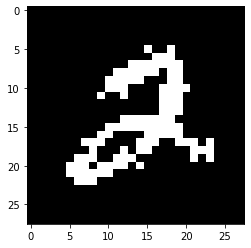

In [4]:
#importo dati mnist e binarizzo

#Loading MNIST dataset
mnist_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

#mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255)

mnist_data.data = (mnist_data.data.type(torch.FloatTensor)/255).bernoulli()
#https://stackoverflow.com/questions/68056122/attributeerror-cant-set-attribute-in-splitting-mnist-dataset

#Lets us visualize a number from the data set
idx = 5
img = mnist_data.train_data[idx]
print("The number shown is the number: {}".format(mnist_data.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

how many models do you want to compare?2
nr epochs or gibbs comparison?(1=nr_epochs, else=gibbs)1
do you want to load an old model? (1=yes, 0=no)1
quante epoche di training della RBM?1
quanti h train generati (0 se nessuno)?1000
con quanti gibbs steps?1
quanti h test generati (0 se nessuno)?1000
con quanti gibbs steps?1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
trainare la rete? quante epoche? (0 se non si vuole trainare0
creare nuovi dati generati (0=no, 1=si, 2=reset)0
salvare il modello? (0=no, 1=si)0


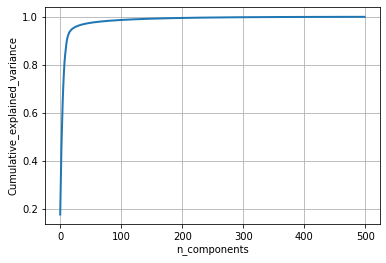

explained variance per component:  [0.17572467 0.15178655]
avg euclidean distance, label=0 : 1.4956761932310958
avg euclidean distance, label=1 : 1.4349653825668964
avg euclidean distance, label=2 : 1.5269681196491998
avg euclidean distance, label=3 : 1.909035163000226
avg euclidean distance, label=4 : 2.047033592492719
avg euclidean distance, label=5 : 2.0574538710774206
avg euclidean distance, label=6 : 1.837182963521857
avg euclidean distance, label=7 : 1.904786769549052
avg euclidean distance, label=8 : 1.9072024849684615
avg euclidean distance, label=9 : 2.1060005256889065
mean distance between the cluster center and all other centers, label 0 = 4.270807001325819
mean distance between the cluster center and all other centers, label 1 = 5.18296127849155
mean distance between the cluster center and all other centers, label 2 = 3.3438984288109674
mean distance between the cluster center and all other centers, label 3 = 2.340670645236969
mean distance between the cluster center and al

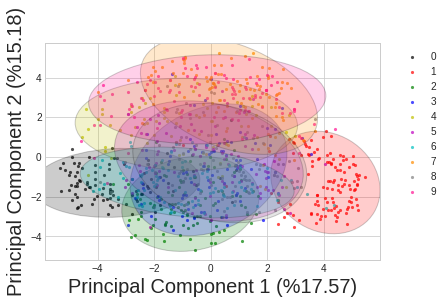

do you want to load an old model? (1=yes, 0=no)1
quante epoche di training della RBM?2
quanti h train generati (0 se nessuno)?1000
con quanti gibbs steps?1
quanti h test generati (0 se nessuno)?1000
con quanti gibbs steps?1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
trainare la rete? quante epoche? (0 se non si vuole trainare0
creare nuovi dati generati (0=no, 1=si, 2=reset)0
salvare il modello? (0=no, 1=si)0


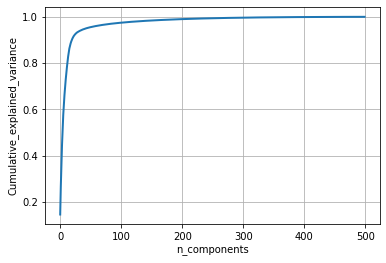

explained variance per component:  [0.14544816 0.12183194]
avg euclidean distance, label=0 : 1.1331158278939815
avg euclidean distance, label=1 : 1.3822381216110569
avg euclidean distance, label=2 : 1.95621464859455
avg euclidean distance, label=3 : 1.7829715023631032
avg euclidean distance, label=4 : 1.9277867762952723
avg euclidean distance, label=5 : 1.7842299114255344
avg euclidean distance, label=6 : 1.7575317693479133
avg euclidean distance, label=7 : 2.054114153081516
avg euclidean distance, label=8 : 1.6328640882583225
avg euclidean distance, label=9 : 1.862889167605614
mean distance between the cluster center and all other centers, label 0 = 4.740992625554402
mean distance between the cluster center and all other centers, label 1 = 5.3090673552619085
mean distance between the cluster center and all other centers, label 2 = 3.3681497044033475
mean distance between the cluster center and all other centers, label 3 = 2.8351715008417764
mean distance between the cluster center and

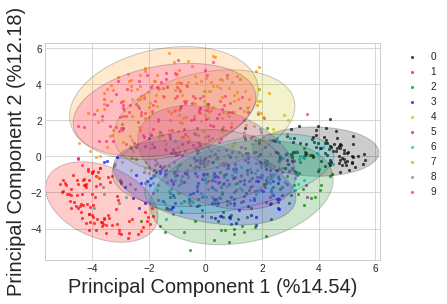

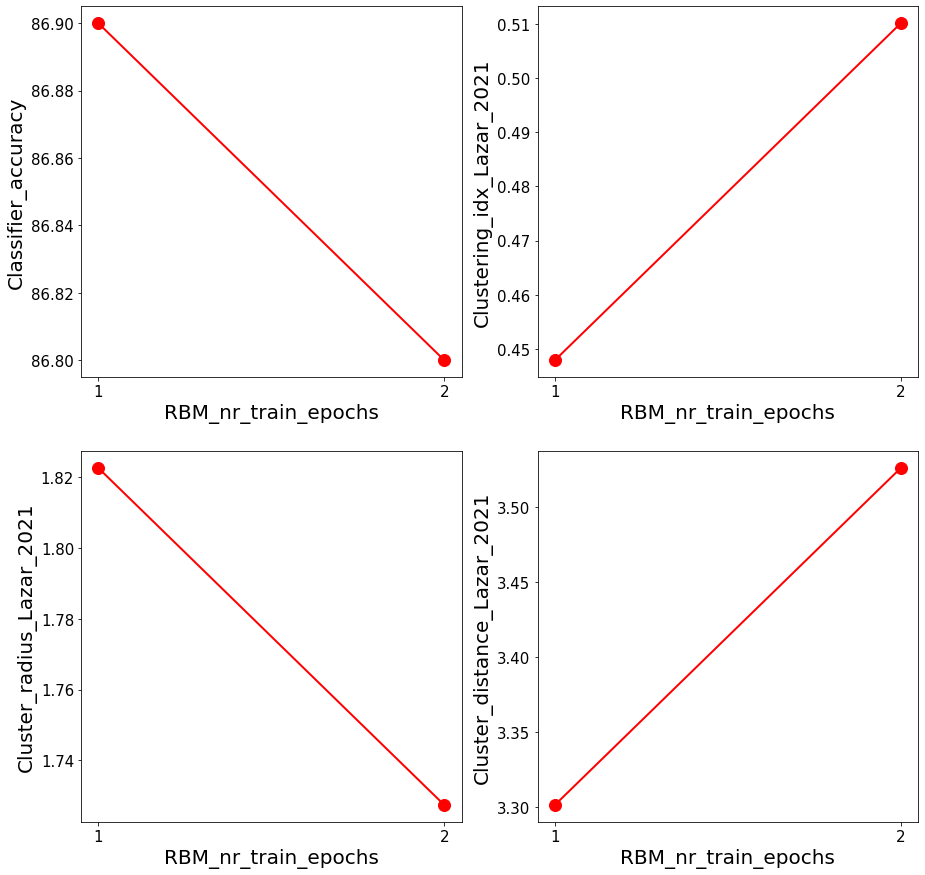

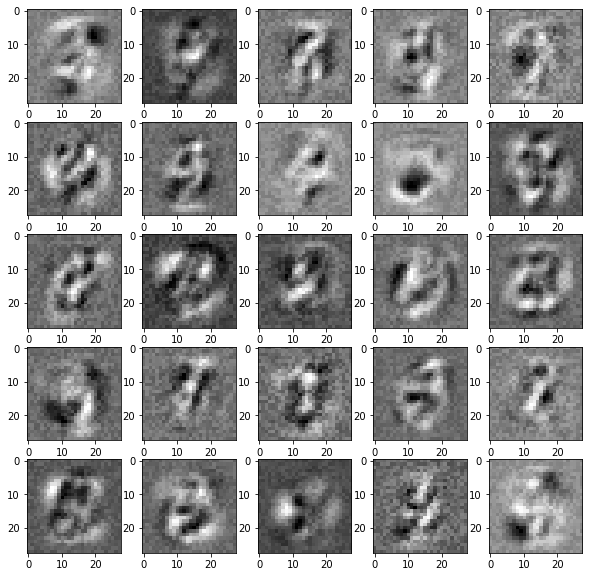

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


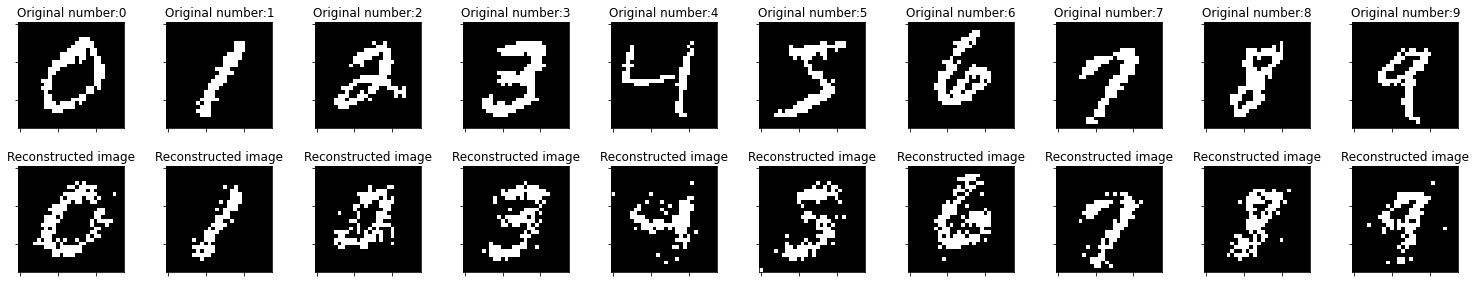

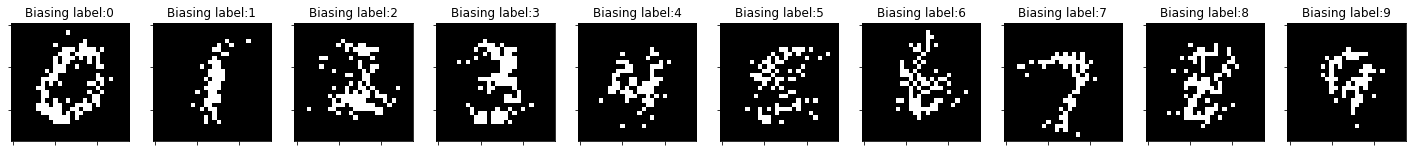

In [14]:
seed_everything(seed=42)
nr_models_to_compare = int(input('how many models do you want to compare?'))
kindof_comparison = int(input('nr epochs or gibbs comparison?' '(1=nr_epochs, else=gibbs)'))
models_list =[]

RBM_nr_train_epochs=[]
nr_gibbs_steps_generated_test_data=[]
Classifier_accuracy=[]
Clustering_idx_Lazar_2021=[]
Cluster_radius_Lazar_2021 = []
Cluster_distance_Lazar_2021 =[]

df_labels = ['RBM_nr_train_epochs','Nr_gibbs_steps_generated_test_data','Classifier_accuracy','Clustering_idx_Lazar_2021','Cluster_radius_Lazar_2021','Cluster_distance_Lazar_2021']

for i in range(nr_models_to_compare):

  model,gib_nr = model_load_or_create()
  models_list.append(model)
  RBM_nr_train_epochs.append(model.nr_train_epochs_done)
  nr_gibbs_steps_generated_test_data.append(gib_nr)
  Classifier_accuracy.append(model.test_h_Linear_classifier())

  path  = '/content/gdrive/My Drive/' + model.filename
  os.chdir(path)

  px = pd.DataFrame(model.h_test_dataset.cpu().numpy())
  y = np.array(model.h_test_labels)
  PCA_explainedVariance_plot(px, model)
  Clustering_idx, avg_Cluster_radius, Avg_Cluster_distance = PCA_analysis(px,y)
  Clustering_idx_Lazar_2021.append(Clustering_idx) 
  Cluster_radius_Lazar_2021.append(avg_Cluster_radius)
  Cluster_distance_Lazar_2021.append(Avg_Cluster_distance)

Model_comparison_df = pd.DataFrame(list(zip(RBM_nr_train_epochs, nr_gibbs_steps_generated_test_data,Classifier_accuracy,Clustering_idx_Lazar_2021,Cluster_radius_Lazar_2021,Cluster_distance_Lazar_2021)),
               columns =df_labels)



Model_Comparison_plot(Model_comparison_df, Plot_nr_epochs = kindof_comparison)

Plot_Weights(model)

Reconstuct_plot(mnist_data,model)

Plot_biased_rec(model)



